In [1]:
import numpy as np
import pandas as pd
from statistics import mode
from copy import deepcopy

pd.set_option('mode.chained_assignment', None)

In [2]:
# data = {
#     'Stream': ['false', 'true', 'true', 'false', 'false', 'true', 'true'],
#     'Slope': ['steep', 'moderate', 'steep', 'steep', 'flat', 'steep', 'steep'],
#     'Elevation': ['high', 'low', 'medium', 'medium', 'high', 'highest', 'high'],
#     'Vegetation': ['chapparal', 'riparian', 'riparian', 'chapparal', 'conifer', 'conifer', 'chapparal']
# }

# df = pd.DataFrame(data)

# X_train, y_train = df.iloc[:, :-1], df.iloc[:, -1]

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)

X, y = data.data, data.target
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Data Preprocessing

In [4]:
# Source: http://gnpalencia.org/optbinning/tutorials/tutorial_binary.html
from optbinning import OptimalBinning

for d in X.columns:
    op = OptimalBinning(name=d, dtype="numerical", solver="cp")
    op.fit(X[d].values, y)
    bins = [0] + list(op.splits) + [X[d].max()]
    X[d] = pd.cut(X[d], bins, labels=range(len(bins)-1))

In [5]:
for d in ['mean concavity', 'mean concave points', 'concavity error', 'concave points error', 'worst concavity', 'worst concave points']:
    X[d].fillna(mode(X[d].values), inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Entropy *(Bits)*
$\mathcal{H}(t, \mathcal{D})=-\sum_{I\in levels(t)\\}^{}{P(t=I)\cdot\log_2(P(t=I))}$

### Rem
$rem(d,\mathcal{D})=\sum_{I\in levels(t)}{}\frac{|\mathcal{D}_{d=I}|}{\mathcal{D}}\cdot \mathcal{H}(t, \mathcal{D}_{d=I})$

### Information Gain
$IG(d, \mathcal{D})=\mathcal{H}(t, \mathcal{D})-rem(d, \mathcal{D})$

In [7]:
class Node:
    def __init__(
        self,
        feature=None,
        data=None,
        branch=None,
        parent=None,
        leaf=False,
        children=[]
    ):
        self.feature = feature
        self.data = data
        self.branch = branch
        self.parent = parent
        self.leaf = leaf
        self.children = children

    @property
    def isLeaf(self):
        return self.leaf

    @property
    def X(self):
        return self.data.iloc[:, :-1]

    @property
    def y(self):
        return self.data.iloc[:, -1]

In [8]:
class DecisionTree:
    """
    A Rudimentary Decision Tree Classifier

    TODO
        - Pruning
    """
    def __init__(self):
        self.root = None
        self.levels = None

    def __repr__(self, node=None, depth=0):
        """Displays the decision tree"""
        if not node:
            node = self.root

        print(depth * '\t', node.feature, f"(Branch={node.branch})")
        for child in node.children:
            self.__repr__(child, depth+1)

        return ""

    def partition(self, X, y, d, t):
        D = pd.concat([X.loc[X[d]==t], y.loc[X[d]==t]], axis=1)
        D = D.drop([d], axis=1)
        return D.iloc[:, :-1], D.iloc[:, -1], t

    def entropy(self, X, y):
        """Measures the amount of uncertainty/impurity/heterogeneity in (X, y)"""
        proba = lambda t: len(X.loc[y==t]) / len(X)
        return -sum([proba(t) * np.log2(proba(t)) for t in y.unique()])

    def rem(self, X, y, d):
        """Measures the entropy after partitioning (X, y) on feature (d)"""
        weight = lambda t: len(X.loc[X[d]==t]) / len(X)
        return sum([weight(t) * self.entropy(X.loc[X[d]==t], y.loc[X[d]==t]) for t in X[d].unique()])

    def information_gain(self, X, y, d):
        """Measures the reduction in the overall entropy in (X, y) achieved by testing on feature (d)"""
        if debug:
            print(f"{d} = {self.entropy(X, y):.3f} - {self.rem(X, y, d):.3f} = {self.entropy(X, y) - self.rem(X, y, d):.3f}") 

        return self.entropy(X, y) - self.rem(X, y, d)

    def build_tree(self, X, y, *, parent=None, branch=None):
        """Performs the ID3 algorithm"""
        if len(y.unique()) == 1:  # all instances have the same target feature values
            if debug:
                print("All instances have the same target feature value\n")
            best_node = Node(feature=y.iat[0],
                             data=pd.concat([X, y], axis=1),
                             branch=branch,
                             parent=parent,
                             leaf=True)
        elif X.empty:  # dataset is empty, return a leaf node labeled with the majority class of the parent
            if debug:
                print("Dataset is empty\n")
            best_node =  Node(feature=mode(parent.y),
                              branch=branch,
                              parent=parent,
                              leaf=True)
        elif all((X[d] == X[d].iloc[0]).all() for d in X.columns):  # if all feature values are identical
            if debug:
                print("All instances have the same descriptive features\n")
            best_node = Node(feature=mode(y),
                             data=pd.concat([X, y], axis=1),
                             branch=branch,
                             parent=parent,
                             leaf=True)

        else:
            if debug:
                print("===Information Gain===")
            best_feature = X.columns[np.argmax([self.information_gain(X, y, d) for d in X.columns])]
            best_node = deepcopy(Node(feature=best_feature,
                                 data=pd.concat([X, y], axis=1),
                                 branch=branch,
                                 parent=parent))

            if debug:
                print()
                print("===Best Feature===")
                print(best_feature)
                print()

            partitions = [self.partition(X, y, best_feature, t) for t in self.levels[best_feature]]

            for *d, t in partitions:
                if debug:
                    print(f"===Partitioned Dataset ({t})===")
                    print(pd.concat([*d], axis=1).head())
                    print()
                best_node.children.append(self.build_tree(*d, parent=best_node, branch=t))
        return best_node

    def fit(self, X, y):
        self.levels = {k: X[k].unique() for k in X.columns}
        self.root = self.build_tree(X, y)
        return self

    def predict(self, x):
        node = self.root
        while not node.isLeaf:
            for child in node.children:
                if child.branch == x.get(node.feature).values:
                    node = child
                    break
        return node.feature

    def score(self, X, y):
        y_hat = [self.predict(X.iloc[x].to_frame().T) for x in range(len(X))]
        return confusion_matrix(y, y_hat, labels=[1, 0])

In [9]:
%%time
debug = 0
dt = DecisionTree().fit(X_train, y_train)

CPU times: user 11.3 s, sys: 129 ms, total: 11.4 s
Wall time: 11.4 s


In [10]:
dt

 worst perimeter (Branch=None)
	 mean concave points (Branch=0)
		 1 (Branch=0)
		 1 (Branch=1)
		 texture error (Branch=4)
			 1 (Branch=2)
			 1 (Branch=5)
			 1 (Branch=9)
			 1 (Branch=1)
			 0 (Branch=6)
			 1 (Branch=4)
			 1 (Branch=8)
			 1 (Branch=3)
			 1 (Branch=7)
			 1 (Branch=0)
		 1 (Branch=6)
		 1 (Branch=5)
		 radius error (Branch=2)
			 1 (Branch=2)
			 1 (Branch=1)
			 1 (Branch=5)
			 1 (Branch=0)
			 0 (Branch=6)
			 1 (Branch=4)
			 1 (Branch=3)
		 1 (Branch=3)
	 mean compactness (Branch=1)
		 mean area (Branch=0)
			 1 (Branch=2)
			 1 (Branch=6)
			 1 (Branch=0)
			 1 (Branch=4)
			 1 (Branch=1)
			 0 (Branch=5)
			 1 (Branch=3)
		 1 (Branch=1)
		 1 (Branch=2)
		 1 (Branch=3)
		 1 (Branch=4)
		 0 (Branch=6)
		 0 (Branch=5)
	 concavity error (Branch=4)
		 0 (Branch=1)
		 0 (Branch=7)
		 0 (Branch=3)
		 1 (Branch=0)
		 0 (Branch=6)
		 0 (Branch=4)
		 0 (Branch=2)
		 0 (Branch=5)
		 0 (Branch=8)
	 worst texture (Branch=3)
		 1 (Branch=0)
		 1 (Branch=1)
		 mean com

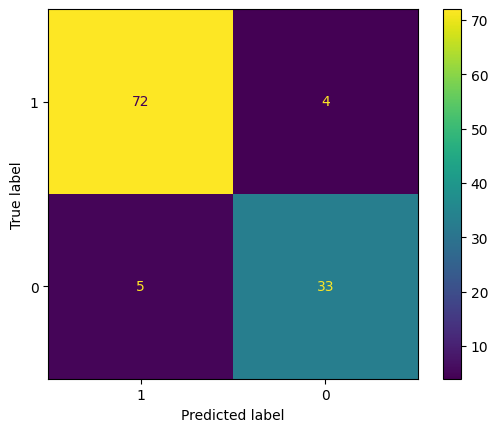

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

score = dt.score(X_test, y_test)
dplt = ConfusionMatrixDisplay(confusion_matrix=score, display_labels=[1, 0])
dplt.plot()

In [12]:
# X_test = pd.DataFrame({'Stream': ['true'],
#                        'Slope': ['steep'],
#                        'Elevation': ['high']})
# type(X_test)
# dt.predict(X_test)

In [13]:
class RandomForest:
    def __init__(self, n_estimators=5, n_sample=2):
        self.n_estimators = n_estimators
        self.n_sample = n_sample
        self.forest = []

    def subsample(self, X, n_sample=2):
        """Enforces feature randomness"""
        return np.random.choice(X.columns.to_numpy(), n_sample, replace=False)

    def make_bootstrap(self, X, y, n_sample, key=True):
        feature_subset = self.subsample(X, int(np.log2(len(X))))
        d = pd.concat([X, y], axis=1)
        d = d.sample(n=n_sample, replace=key)
        return d.iloc[:, :-1][feature_subset], d.iloc[:, -1]

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            a, b = self.make_bootstrap(X, y, self.n_sample)
            i = DecisionTree().fit(a, b)
#             print(f"===Decision Tree {_+1}===\n")
#             print(pd.concat([a, b], axis=1))
#             print()
#             print(i)
#             print()
            self.forest.append(i)
        # self.forest = [DecisionTree().fit(*self.make_bootstrap(X, y, self.n_sample))
        #                for _ in range(self.n_estimators)]
        return self

    def predict(self, x):
        """Aggregation"""
        assert all(isinstance(model, DecisionTree) for model in self.forest)
        return mode([dt.predict(x) for dt in self.forest])

    def score(self, X, y):
        y_hat = [self.predict(X.iloc[x].to_frame().T) for x in range(len(X))]
        return confusion_matrix(y, y_hat, labels=[1, 0])

In [14]:
%%time
rf = RandomForest(n_estimators=10, n_sample=len(X_train)).fit(X_train, y_train)

CPU times: user 22.2 s, sys: 355 ms, total: 22.6 s
Wall time: 22.5 s


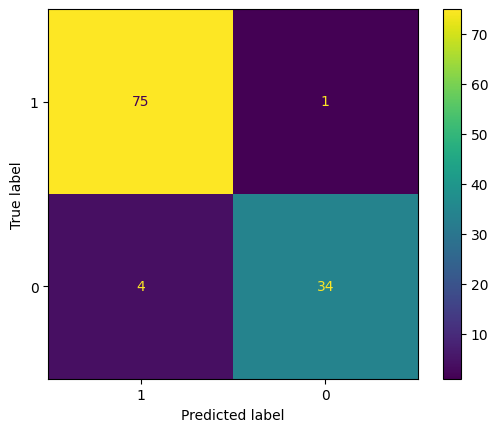

In [15]:
score = rf.score(X_test, y_test)
dplt = ConfusionMatrixDisplay(confusion_matrix=score, display_labels=[1, 0])
dplt.plot()

In [16]:
# X_test = pd.DataFrame({'Stream': ['true'],
#                        'Slope': ['steep'],
#                        'Elevation': ['high']})
# rf.predict(X_test)